# Install required packages

In [ ]:
!pip install xlstm
!pip install Ninja
!pip install torch-summary

# Imports

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
from xlstm import (
    xLSTMBlockStack,
    xLSTMBlockStackConfig,
    mLSTMBlockConfig,
    mLSTMLayerConfig,
    sLSTMBlockConfig,
)
from torch.utils.data import TensorDataset, DataLoader
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from torchsummary import summary
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import HTML
import os


seed = 211
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# General Constants

In [3]:
config_dict = {
    "data": {
        "rolling_window": 10,
        "lookback": 100,
        "horizon": 1,
        "split_ratios": {'train': 0.64, 'val': 0.16, 'test': 0.2},
    },
    "model": {
        "num_features": 6,
        "num_blocks": 3,
        "embedding_dim": 128,
        "context_length": 336,
        "sma_ksize": 25
    },
    "training": {
        "batch_size": 64,
        "epochs": 50,
        "lr": 1e-4,
        "min_lr": 1e-7,
        "sched_factor": 0.5,
        "sched_threshold": 1e-5
    },
}

In [4]:
# Commonly used constants
offset = config_dict['data']['rolling_window'] // 2
lookback = config_dict['data']['lookback']
horizon = config_dict['data']['horizon']
batch_size = config_dict['training']['batch_size']
epochs = config_dict['training']['epochs']

# Submodule and Model Definitions

In [5]:
class RevIN(nn.Module):
    def __init__(self, num_features: int, eps=1e-5, affine=True):
        """
        :param num_features: the number of features or channels
        :param eps: a value added for numerical stability
        :param affine: if True, RevIN has learnable affine parameters
        """
        super(RevIN, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.affine = affine
        if self.affine:
            self._init_params()

    def forward(self, x, mode:str):
        if mode == 'norm':
            self._get_statistics(x)
            x = self._normalize(x)
        elif mode == 'denorm':
            x = self._denormalize(x)
        else: raise NotImplementedError
        return x

    def _init_params(self):
        # initialize RevIN params: (C,)
        self.affine_weight = nn.Parameter(torch.ones(self.num_features))
        self.affine_bias = nn.Parameter(torch.zeros(self.num_features))

    def _get_statistics(self, x):
        dim2reduce = tuple(range(1, x.ndim-1))
        self.mean = torch.mean(x, dim=dim2reduce, keepdim=True).detach()
        self.stdev = torch.sqrt(torch.var(x, dim=dim2reduce, keepdim=True, unbiased=False) + self.eps).detach()

    def _normalize(self, x):
        x = x - self.mean
        x = x / self.stdev
        if self.affine:
            x = x * self.affine_weight
            x = x + self.affine_bias
        return x

    def _denormalize(self, x):
        if self.affine:
            x = x - self.affine_bias
            x = x / (self.affine_weight + self.eps*self.eps)
        x = x * self.stdev
        x = x + self.mean
        return x

In [6]:
class Config:
    def __init__(self, seq_len, fcast_horizon, emb_dim2, sma_ksize, num_features):
        self.seq_len = seq_len
        self.fcast_horizon = fcast_horizon
        self.emb_dim2 = emb_dim2
        self.sma_ksize = sma_ksize
        self.num_features = num_features

In [7]:
class SMA(nn.Module):
    """
    Simple moving average (SMA) block to capture the trend
    """
    def __init__(self, kernel_size):
        super(SMA, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=1, padding=0)

    def forward(self, x):
        # pad both ends of the time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        back = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, back], dim=1)
        x = self.avg(x.permute(0, 2, 1)) # Averaging is done on the 3rd dim, but we want the 2nd
        x = x.permute(0, 2, 1) # Permute back to original dimensions
        return x

In [8]:
class decomp(nn.Module):
    """
    Decomposition block for seasonal and trend
    """
    def __init__(self, kernel_size):
        super(decomp, self).__init__()
        self.sma = SMA(kernel_size)

    def forward(self, x):
        trend = self.sma(x)
        seasonal = x - trend
        return seasonal, trend

In [9]:
class xlstm(nn.Module):
    def __init__(self, cfg, bs_cfg):
        super(xlstm, self).__init__()

        self.bn = nn.BatchNorm1d(cfg.num_features)

        # Seasonal/Trend layers
        self.decomp = decomp(kernel_size=cfg.sma_ksize)
        self.LinearSeasonal = nn.Linear(cfg.seq_len, cfg.fcast_horizon)
        self.LinearTrend = nn.Linear(cfg.seq_len, cfg.fcast_horizon)
        self.LinearDecoder = nn.Linear(cfg.seq_len, cfg.fcast_horizon)

        self.LinearSeasonal.weight = nn.Parameter(
            (1 / cfg.seq_len) * torch.ones([cfg.fcast_horizon, cfg.seq_len])
        )
        self.LinearTrend.weight = nn.Parameter(
            (1 / cfg.seq_len) * torch.ones([cfg.fcast_horizon, cfg.seq_len])
        )

        self.mm1 = nn.Linear(cfg.fcast_horizon, cfg.emb_dim2)
        self.mm2 = nn.Linear(bs_cfg.embedding_dim, cfg.fcast_horizon)
        self.mm3 = nn.Linear(cfg.seq_len, cfg.emb_dim2)

        self.revin = RevIN(cfg.num_features)

        self.xlstm_stack = xLSTMBlockStack(bs_cfg)

    def forward(self, x):
        x = self.revin(x, 'norm')

        seasonal, trend = self.decomp(x)
        seasonal, trend = seasonal.permute(0, 2, 1), trend.permute(0, 2, 1)

        seasonal_out = self.LinearSeasonal(seasonal)
        trend_out = self.LinearTrend(trend)
        x = seasonal_out + trend_out

        x = self.mm1(x)
        x = self.xlstm_stack(x)
        x = self.mm2(x)

        x = x.permute(0, 2, 1)

        x = self.revin(x, 'denorm')

        return x


In [10]:
class trainer:
    def __init__(self, company, ticker):
        self.company = company
        self.ticker = ticker
        self.model_stats = None
        self.trained = False
        self.has_all_predictions = False
        self.has_set_indices = False
        self.anim = None
        self.losses = {'Train': None, 'Validation': None, 'Test': None}
        self.__download_and_preprocess_data()
        self.__create_set_tensors()
        self.__init_model()


    def __download_and_preprocess_data(self):
        df_raw = yf.download(tickers=self.ticker, progress=False)
        df_raw = df_raw.reset_index(drop=True)
        df_raw = df_raw[["Open", "High", "Low", "Close", "Volume", "Adj Close"]]
        df_raw.to_csv(self.ticker, index=False, header=False)
        df = pd.read_csv(self.ticker, header=None)
        df = df.rolling(config_dict['data']['rolling_window']).mean()
        df.dropna(how='any', axis=0, inplace=True)

        # Convert price series to log
        for column in df.columns:
            if column != "Volume":
                df[column] = np.log(df[column])

        dataset = df.values.astype('float32')

        self.df_raw = df_raw
        self.df = df
        self.scaler = MinMaxScaler()
        self.dataset = self.scaler.fit_transform(dataset)


    def __create_features_labels(self, dataset, lookback, horizon):
        X, y = [], []
        for i in range(len(dataset) - lookback - horizon):
            X.append(dataset[i: i + lookback])
            y.append(dataset[i + lookback: i + lookback + horizon])

        return torch.from_numpy(np.array(X)).float(), torch.from_numpy(np.array(y)).float()


    def __create_set_tensors(self):
        full_size = len(self.dataset)
        train_size = int(full_size * config_dict["data"]["split_ratios"]['train'])
        val_size = int(full_size * config_dict["data"]["split_ratios"]['val'])

        train_set = self.dataset[:train_size, :]
        val_set = self.dataset[train_size: train_size + val_size, :]
        test_set = self.dataset[train_size + val_size:, :]

        X_train, y_train = self.__create_features_labels(train_set, lookback, horizon)
        X_val, y_val = self.__create_features_labels(val_set, lookback, horizon)
        X_test, y_test = self.__create_features_labels(test_set, lookback, horizon)

        self.train_set_tensor = TensorDataset(X_train, y_train)
        self.val_set_tensor = TensorDataset(X_val, y_val)
        self.test_set_tensor = TensorDataset(X_test, y_test)

        self.train_len = len(self.train_set_tensor)
        self.val_len = len(self.val_set_tensor)
        self.test_len = len(self.test_set_tensor)


    def __init_data_loaders(self, shuffle_train=True):
        batch_size = config_dict["training"]["batch_size"]
        self.train_loader = DataLoader(self.train_set_tensor, batch_size=batch_size, shuffle=shuffle_train)
        self.val_loader = DataLoader(self.val_set_tensor, batch_size=batch_size, shuffle=False)
        self.test_loader = DataLoader(self.test_set_tensor, batch_size=batch_size, shuffle=False)


    def __init_model(self):
        block_stack_config = xLSTMBlockStackConfig(
            mlstm_block = mLSTMBlockConfig(mlstm=mLSTMLayerConfig(bias=True)),
            slstm_block = sLSTMBlockConfig(),
            num_blocks = config_dict["model"]["num_blocks"],
            embedding_dim = config_dict["model"]["embedding_dim"],
            add_post_blocks_norm = True,
            _block_map = 1,
            context_length = config_dict["model"]["context_length"],
        )

        config = Config(
            seq_len = config_dict['data']['lookback'],
            fcast_horizon = config_dict['data']['horizon'],
            emb_dim2 = config_dict["model"]["embedding_dim"],
            sma_ksize = config_dict["model"]["sma_ksize"],
            num_features = config_dict["model"]["num_features"]
        )

        self.model = xlstm(cfg=config, bs_cfg=block_stack_config).to(device)


    def __init_train(self):
        self.criterion = nn.MSELoss(reduction='mean')
        self.optimizer = optim.RAdam(self.model.parameters(), lr=config_dict["training"]["lr"])
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            factor = config_dict["training"]["sched_factor"],
            threshold = config_dict["training"]["sched_threshold"],
            min_lr=config_dict["training"]["min_lr"],
            patience=1
        )


    def train(self, verbose_progress=True):
        self.__init_train()
        self.__init_data_loaders()

        train_losses = []
        val_losses = []
        epochs = config_dict["training"]["epochs"]
        start_time = time.time()

        # Training loop
        for epoch in range(epochs):
            self.model.train()
            running_train_loss = 0.0
            epoch_time = time.time()

            for i, (X_batch, y_batch) in enumerate(self.train_loader, 0):
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

                outputs = self.model(X_batch)
                train_loss = self.criterion(torch.exp(outputs[:, :, -1]), torch.exp(y_batch[:, :, -1]))
                self.optimizer.zero_grad()
                train_loss.backward()
                self.optimizer.step()

                running_train_loss += train_loss.item() * X_batch.size(0);

            # Avg. training loss for the current epoch
            epoch_train_loss = running_train_loss / len(self.train_loader.dataset)
            train_losses.append(epoch_train_loss)

            # Validation phase
            epoch_val_loss = self.__evaluate()
            val_losses.append(epoch_val_loss)
            self.scheduler.step(epoch_val_loss)


            # Print statistics
            if verbose_progress and ((epoch + 1) % 5 == 0 or epoch == 0):
                avg_epoch_time = (time.time() - start_time) / (epoch + 1)
                print(f'Epoch [{epoch + 1}/{epochs}]  |  '
                      f'Avg. Epoch Time: {avg_epoch_time:.2f} sec  |  '
                      f'Train Loss: {epoch_train_loss:.3E}  |  '
                      f'Val Loss: {epoch_val_loss:.3E}  |  '
                      f'LR: {self.scheduler.get_last_lr()[-1]:.3E}')

        ### end for epoch in range(epochs)...

        self.train_losses = train_losses
        self.val_losses = val_losses
        self.trained = True


    def __evaluate(self):
        self.model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for _, (X_batch, y_batch) in enumerate(self.val_loader, 0):
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                val_outputs = self.model(X_batch)
                val_loss = self.criterion(torch.exp(val_outputs[:, :, -1]), torch.exp(y_batch[:, :, -1]))
                running_val_loss += val_loss.item() * X_batch.size(0);

        epoch_val_loss = running_val_loss / len(self.val_loader.dataset)
        return epoch_val_loss


    def __predict(self, data_loader, data_desc):
        self.model.eval()

        predicted_prices = np.array([])
        running_loss = 0.0
        with torch.no_grad():
            for _, (X_batch, y_batch) in enumerate(data_loader):
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

                # Get predictions
                preds = self.model(X_batch)
                loss = self.criterion(torch.exp(preds[:, :, -1]), torch.exp(y_batch[:, :, -1]))
                running_loss += loss.item() * X_batch.size(0)

                preds = preds.cpu().numpy()
                preds = np.array(
                    [self.scaler.inverse_transform(preds[i]) for i in range(preds.shape[0])]
                )

                predicted_prices = np.concatenate((predicted_prices, np.exp(preds[:, -1, -1])))

            total_loss = running_loss / len(data_loader.dataset)

        self.losses[data_desc] = total_loss
        return predicted_prices


    def print_model_stats(self):
        if self.model_stats is None:
            self.model_stats = summary(
                model = self.model,
                dtypes = [torch.float, torch.float],
                batch_dim = 1,
                device = device,
                verbose = 0
            )

        print(str(self.model_stats))


    def plot_losses(self, from_epoch=0):
        if self.trained == False:
            raise AttributeError('Model has not been trained')

        if from_epoch < 0 or from_epoch > epochs - 1:
            raise ValueError(f'from_epoch must be in the range [0, {epochs - 1}]')

        indices = np.arange(from_epoch, epochs)

        plt.figure(figsize=(10, 6))
        plt.plot(indices, self.train_losses[from_epoch:], label='Training Loss', color='blue')
        plt.plot(indices, self.val_losses[from_epoch:], label='Validation Loss', color='red')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Training and Validation Losses Vs. Epochs, Last {self.company}')
        plt.legend()
        plt.show()


    def __get_all_predictions(self):
        self.__init_data_loaders(shuffle_train=False)
        loaders = [self.train_loader, self.val_loader, self.test_loader]
        descriptions = ['Train', 'Validation', 'Test']
        all_predictions = np.array([])
        for i, loader in enumerate(loaders):
            pred = self.__predict(loader, descriptions[i])
            all_predictions = np.concatenate((all_predictions, pred))

        self.all_predictions = all_predictions


    def __get_set_indices(self):
        self.train_begin_idx = lookback + offset
        self.train_end_idx   = lookback + self.train_len + offset
        self.val_begin_idx   = 2*lookback + self.train_len + offset
        self.val_end_idx     = 2*lookback + self.train_len + self.val_len + offset
        self.test_begin_idx  = 3*lookback + self.train_len + self.val_len + offset
        self.test_end_idx    = 3*lookback + self.train_len + self.val_len + self.test_len + offset


    def plot_set(self, sets):
        if self.trained == False:
            raise AttributeError('Model has not been trained')

        if (sets != 'all') and (sets != 'test') and (sets != 'rwkv'):
            raise ValueError("Argument 'sets' must be either 'all', 'test' or 'rwkv'")

        if self.has_all_predictions == False:
            self.__get_all_predictions()
            self.has_all_predictions = True

        if self.has_set_indices == False:
            self.__get_set_indices()
            self.has_set_indices = True

        if sets == 'test':
            print(f"Test loss: {self.losses['Test']:.3E}")

        plt.figure(figsize=(25, 5))
        if sets == 'test':
            df_raw_test = self.df_raw[self.test_begin_idx: self.test_end_idx].reset_index(drop=True)
            plt.plot(df_raw_test['Adj Close'], label='Actual Prices', color='orange')
            plt.plot(self.all_predictions[self.train_len + self.val_len:], label='Forecasted Prices', color='magenta')
            title_str = f'Forecasted & Actual Prices, xLSTM, 1d Horizon, Test Set, {self.company}'

        elif sets == 'rwkv':
            file_name = self.ticker + '_RWKV.csv'
            if os.path.isfile(file_name) == False:
                url = 'https://raw.githubusercontent.com/GalMichaeli/Stock-Price-Forecasting-with-xLSTM/refs/heads/main/data/' + file_name
                !wget {url}
            df_rwkv = pd.read_csv(file_name)
            df_cleaned = df_rwkv.dropna()
            df_cleaned = df_cleaned.reset_index(drop=True)
            len_to_comp = len(df_cleaned) # RWKV data is smaller
            plt.plot(self.df_raw['Adj Close'][-len_to_comp - offset:].reset_index(drop=True), label='Actual Prices', color='orange')
            plt.plot(self.all_predictions[-len_to_comp:], label='XLSTM Forecasted Prices', color='magenta')
            plt.plot(df_cleaned, label='RWKV Forecasted Prices', color='purple')
            title_str = f'xLSTM, RWKV, Actual, 1d Horizon, Last {len_to_comp} Days of Test Set, {self.company}'

        else:
            plt.plot(self.df_raw['Adj Close'],  label='Ground Truth Prices', color='orange')
            plt.plot(np.arange(self.train_begin_idx, self.train_end_idx), self.all_predictions[:self.train_len], label='Train Forecasted Prices', color='purple')
            plt.plot(np.arange(self.val_begin_idx, self.val_end_idx), self.all_predictions[self.train_len:self.train_len + self.val_len], label='Validation Forecasted Prices', color='blue')
            plt.plot(np.arange(self.test_begin_idx, self.test_end_idx), self.all_predictions[self.train_len + self.val_len:], label='Test Forecasted Prices', color='magenta')
            title_str = f'Forecasted & Actual Prices, xLSTM, 1d Horizon, All Sets, {self.company}'

        plt.xlabel('Days')
        plt.ylabel('Stock Price [USD]')
        plt.title(title_str)
        plt.legend()
        plt.grid()
        plt.show()



# Forecasting Coca-Cola

In [11]:
KO_trainer = trainer('Coca Cola', 'KO')

In [12]:
KO_trainer.print_model_stats()

Layer (type:depth-idx)                   Param #
├─BatchNorm1d: 1-1                       12
├─decomp: 1-2                            --
|    └─SMA: 2-1                          --
|    |    └─AvgPool1d: 3-1               --
├─Linear: 1-3                            101
├─Linear: 1-4                            101
├─Linear: 1-5                            101
├─Linear: 1-6                            256
├─Linear: 1-7                            129
├─Linear: 1-8                            12,928
├─RevIN: 1-9                             12
├─xLSTMBlockStack: 1-10                  --
|    └─ModuleList: 2-2                   --
|    |    └─mLSTMBlock: 3-2              109,448
|    |    └─mLSTMBlock: 3-3              109,448
|    |    └─mLSTMBlock: 3-4              109,448
|    └─LayerNorm: 2-3                    128
Total params: 342,112
Trainable params: 342,112
Non-trainable params: 0


In [13]:
KO_trainer.train()

Epoch [1/50]  |  Avg. Epoch Time: 5.04 sec  |  Train Loss: 2.419E-04  |  Val Loss: 6.731E-05  |  LR: 1.000E-04
Epoch [5/50]  |  Avg. Epoch Time: 3.68 sec  |  Train Loss: 1.988E-06  |  Val Loss: 1.374E-06  |  LR: 1.000E-04
Epoch [10/50]  |  Avg. Epoch Time: 3.44 sec  |  Train Loss: 7.995E-07  |  Val Loss: 6.423E-07  |  LR: 1.000E-04
Epoch [15/50]  |  Avg. Epoch Time: 3.38 sec  |  Train Loss: 4.296E-07  |  Val Loss: 3.934E-07  |  LR: 5.000E-05
Epoch [20/50]  |  Avg. Epoch Time: 3.36 sec  |  Train Loss: 3.488E-07  |  Val Loss: 4.264E-07  |  LR: 1.250E-05
Epoch [25/50]  |  Avg. Epoch Time: 3.35 sec  |  Train Loss: 3.050E-07  |  Val Loss: 3.145E-07  |  LR: 6.250E-06
Epoch [30/50]  |  Avg. Epoch Time: 3.32 sec  |  Train Loss: 2.862E-07  |  Val Loss: 3.160E-07  |  LR: 1.563E-06
Epoch [35/50]  |  Avg. Epoch Time: 3.30 sec  |  Train Loss: 2.814E-07  |  Val Loss: 3.082E-07  |  LR: 3.906E-07
Epoch [40/50]  |  Avg. Epoch Time: 3.29 sec  |  Train Loss: 2.805E-07  |  Val Loss: 3.093E-07  |  LR: 1.95

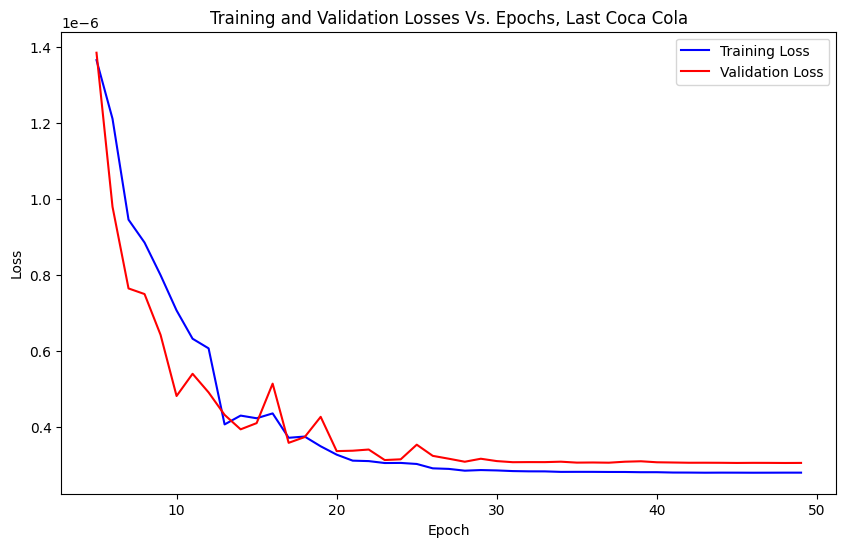

In [14]:
%matplotlib inline
KO_trainer.plot_losses(from_epoch=5)

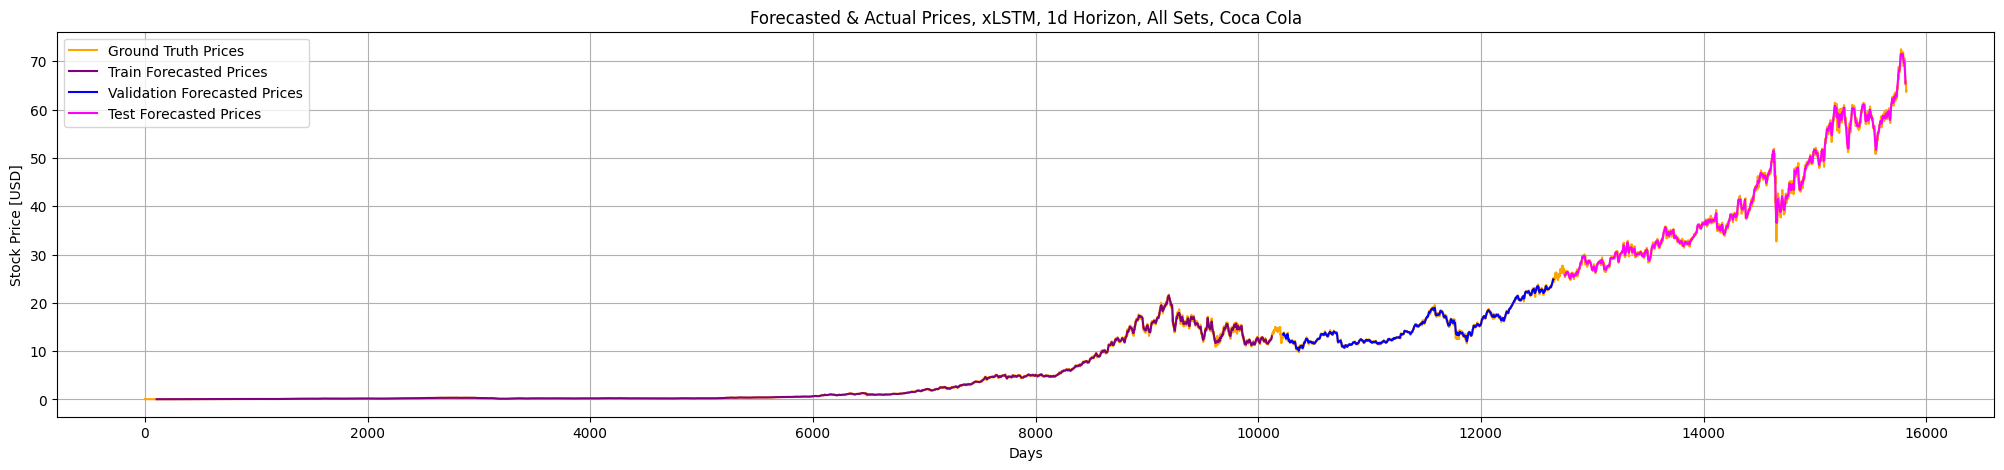

In [15]:
KO_trainer.plot_set('all')

Test loss: 3.190E-07


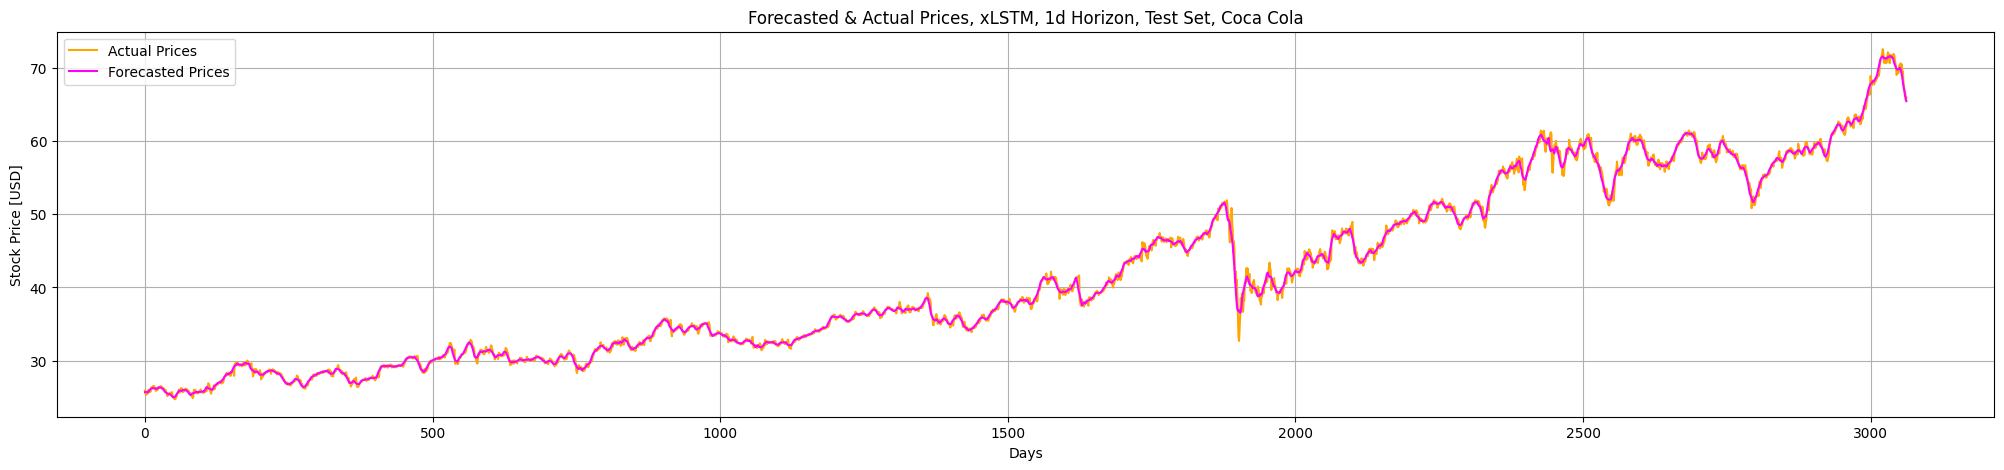

In [16]:
KO_trainer.plot_set('test')

--2024-11-09 16:18:28--  https://raw.githubusercontent.com/GalMichaeli/Stock-Price-Forecasting-with-xLSTM/refs/heads/main/data/KO_RWKV.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65882 (64K) [text/plain]
Saving to: ‘KO_RWKV.csv’

KO_RWKV.csv         100%[===================>]  64.34K  --.-KB/s    in 0.001s  

2024-11-09 16:18:28 (50.4 MB/s) - ‘KO_RWKV.csv’ saved [65882/65882]



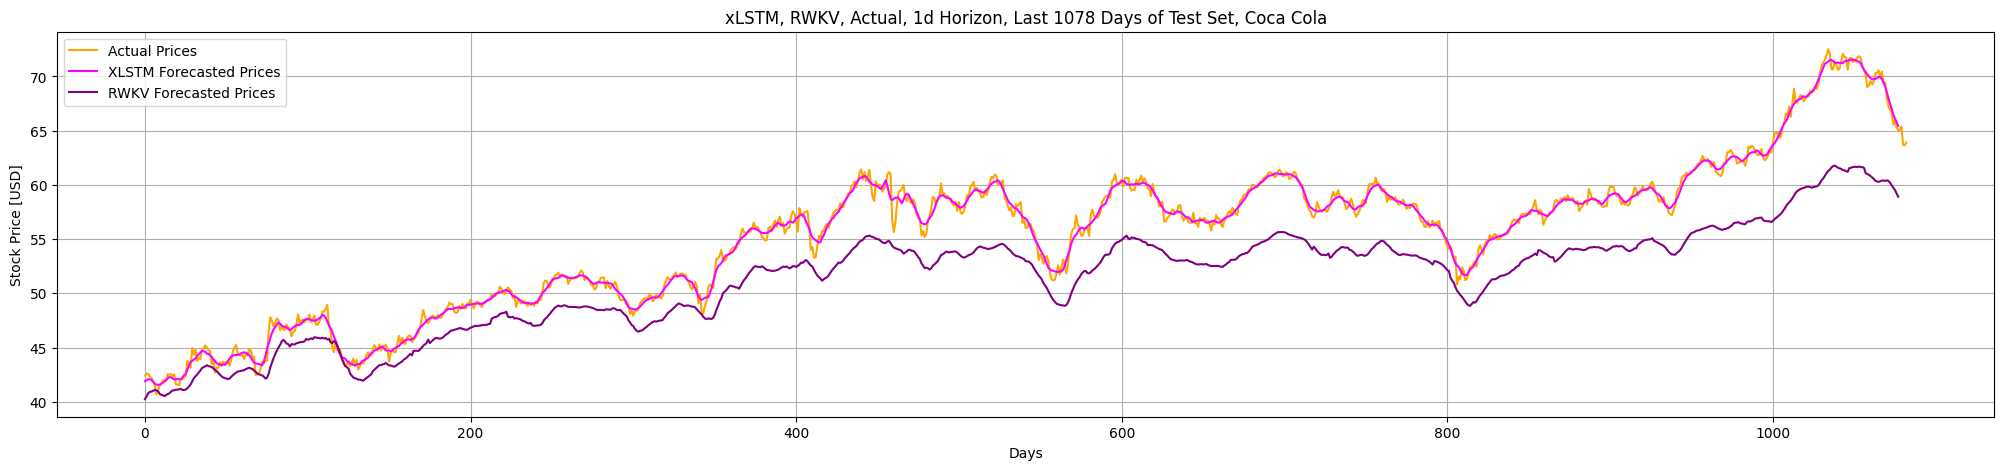

In [17]:
KO_trainer.plot_set('rwkv')

# Forecasting Pfizer

In [18]:
PFE_trainer = trainer('Pfizer', 'PFE')
PFE_trainer.train()

Epoch [1/50]  |  Avg. Epoch Time: 2.72 sec  |  Train Loss: 4.619E-04  |  Val Loss: 2.527E-04  |  LR: 1.000E-04
Epoch [5/50]  |  Avg. Epoch Time: 2.66 sec  |  Train Loss: 4.894E-06  |  Val Loss: 4.126E-06  |  LR: 1.000E-04
Epoch [10/50]  |  Avg. Epoch Time: 2.66 sec  |  Train Loss: 1.521E-06  |  Val Loss: 1.615E-06  |  LR: 1.000E-04
Epoch [15/50]  |  Avg. Epoch Time: 2.66 sec  |  Train Loss: 1.034E-06  |  Val Loss: 1.296E-06  |  LR: 5.000E-05
Epoch [20/50]  |  Avg. Epoch Time: 2.65 sec  |  Train Loss: 8.751E-07  |  Val Loss: 8.307E-07  |  LR: 5.000E-05
Epoch [25/50]  |  Avg. Epoch Time: 2.65 sec  |  Train Loss: 6.670E-07  |  Val Loss: 1.072E-06  |  LR: 2.500E-05
Epoch [30/50]  |  Avg. Epoch Time: 2.65 sec  |  Train Loss: 6.610E-07  |  Val Loss: 6.212E-07  |  LR: 2.500E-05
Epoch [35/50]  |  Avg. Epoch Time: 2.65 sec  |  Train Loss: 6.073E-07  |  Val Loss: 5.936E-07  |  LR: 2.500E-05
Epoch [40/50]  |  Avg. Epoch Time: 2.65 sec  |  Train Loss: 5.267E-07  |  Val Loss: 5.539E-07  |  LR: 6.25

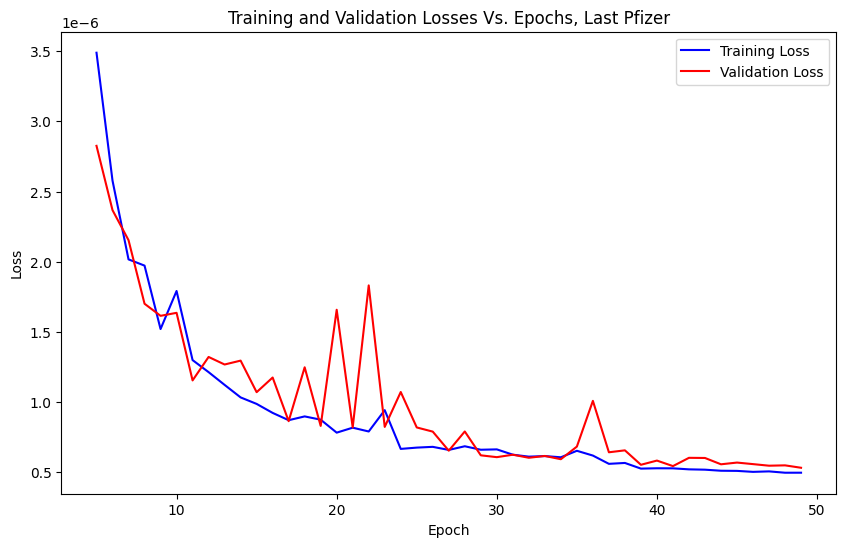

In [19]:
PFE_trainer.plot_losses(5)

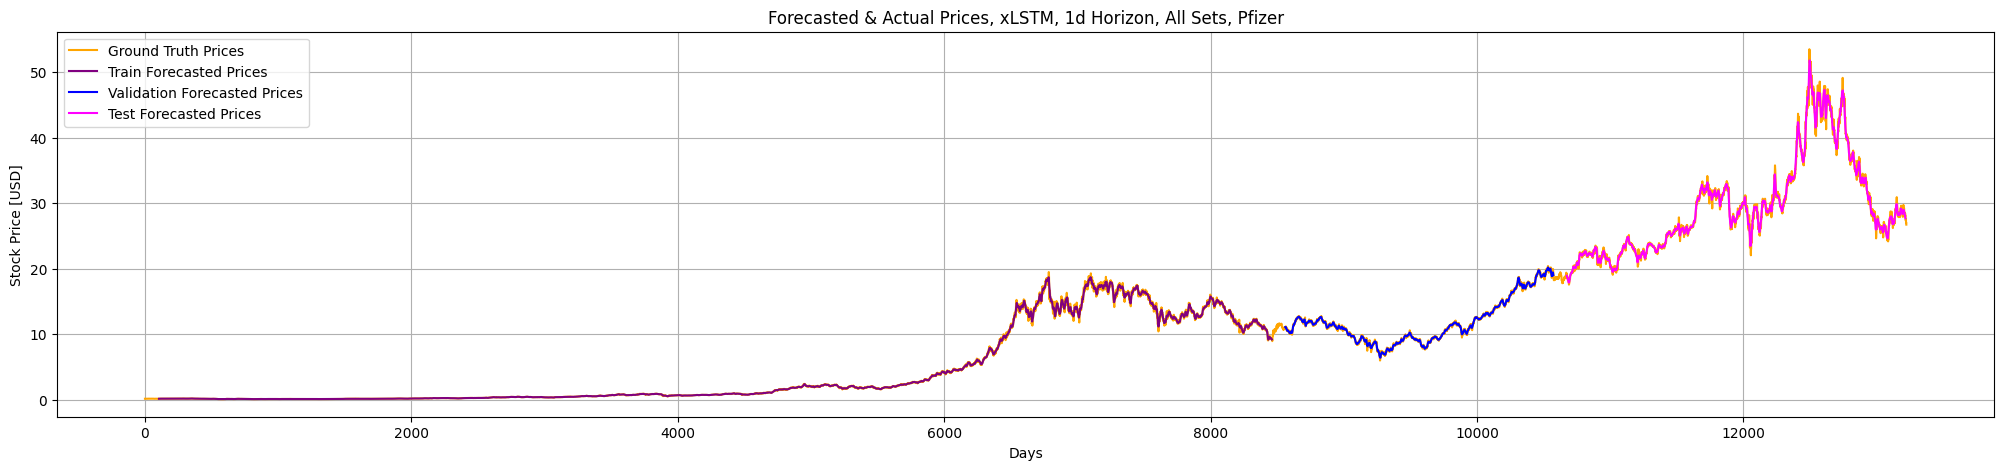

In [20]:
PFE_trainer.plot_set('all')

Test loss: 7.549E-07


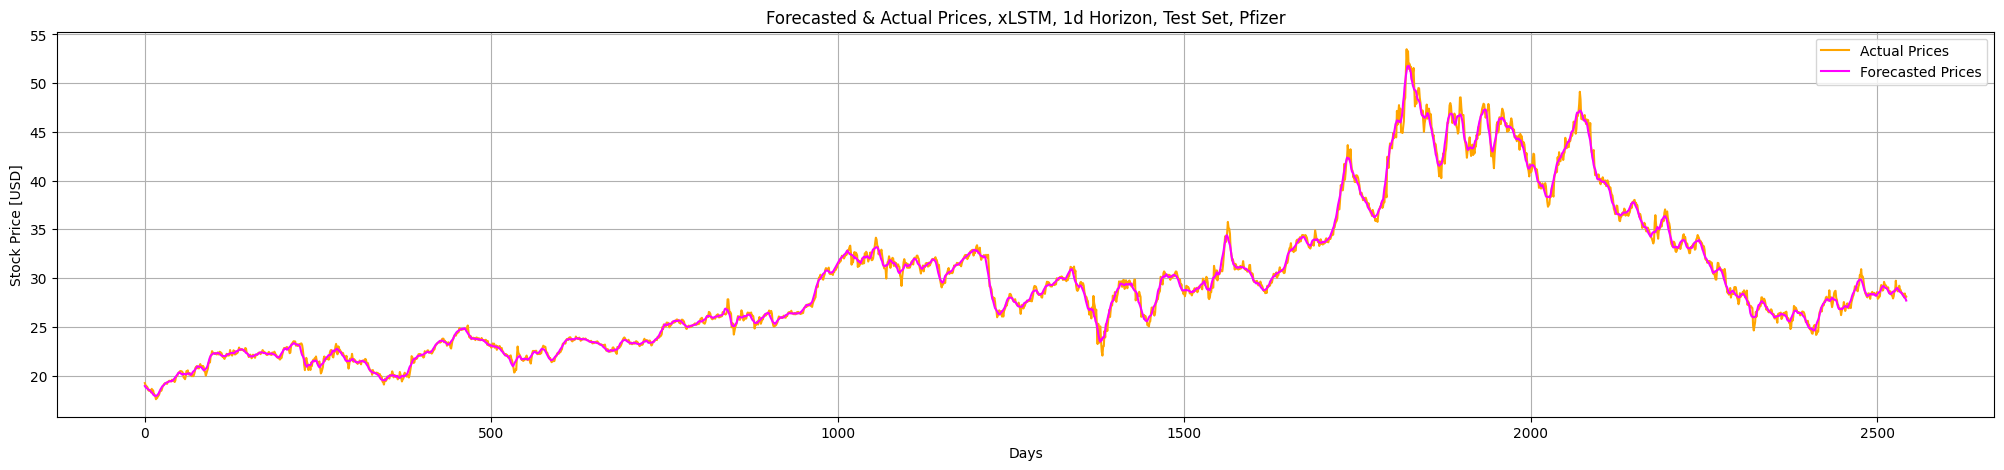

In [21]:
PFE_trainer.plot_set('test')

--2024-11-09 16:20:45--  https://raw.githubusercontent.com/GalMichaeli/Stock-Price-Forecasting-with-xLSTM/refs/heads/main/data/PFE_RWKV.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50026 (49K) [text/plain]
Saving to: ‘PFE_RWKV.csv’

PFE_RWKV.csv        100%[===================>]  48.85K  --.-KB/s    in 0.001s  

2024-11-09 16:20:45 (40.1 MB/s) - ‘PFE_RWKV.csv’ saved [50026/50026]



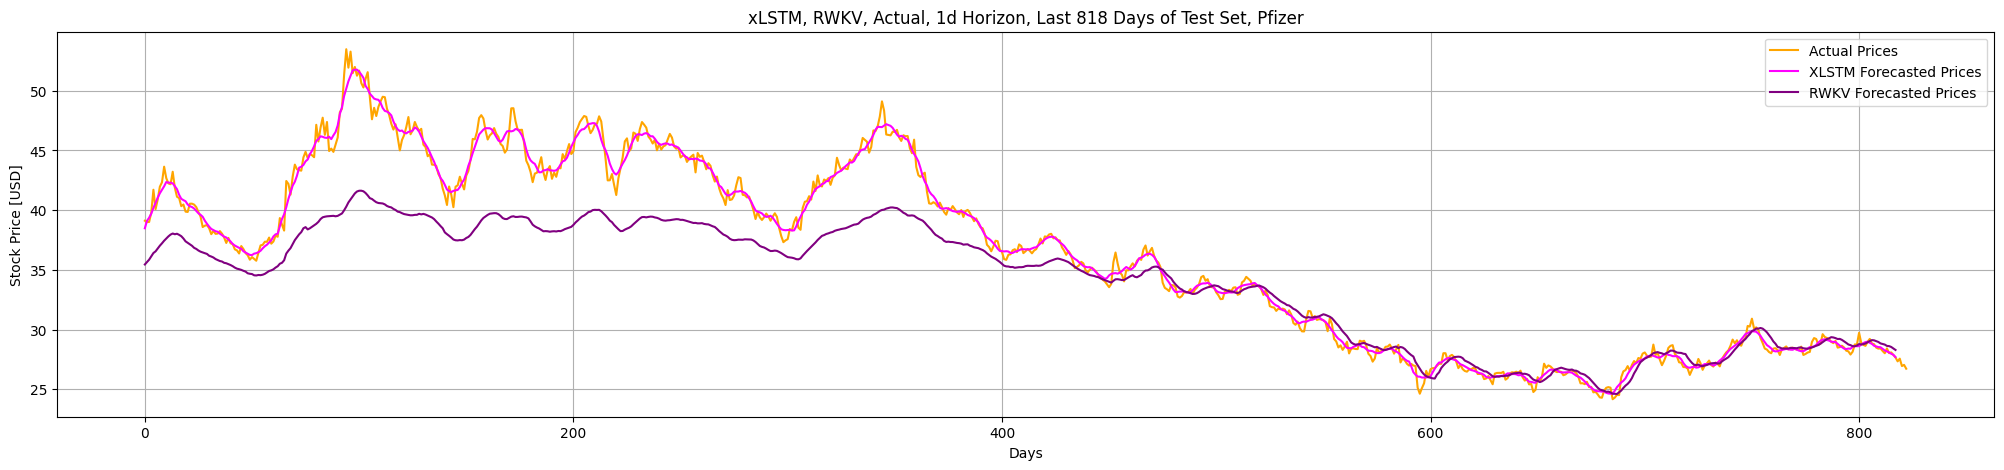

In [22]:
PFE_trainer.plot_set('rwkv')

# Forecasting Amazon

In [23]:
AMZN_trainer = trainer('Amazon', 'AMZN')
AMZN_trainer.train()

Epoch [1/50]  |  Avg. Epoch Time: 1.44 sec  |  Train Loss: 1.666E-03  |  Val Loss: 7.262E-04  |  LR: 1.000E-04
Epoch [5/50]  |  Avg. Epoch Time: 1.38 sec  |  Train Loss: 1.026E-04  |  Val Loss: 2.444E-05  |  LR: 1.000E-04
Epoch [10/50]  |  Avg. Epoch Time: 1.38 sec  |  Train Loss: 1.386E-05  |  Val Loss: 6.402E-06  |  LR: 1.000E-04
Epoch [15/50]  |  Avg. Epoch Time: 1.37 sec  |  Train Loss: 5.416E-06  |  Val Loss: 2.709E-06  |  LR: 5.000E-05
Epoch [20/50]  |  Avg. Epoch Time: 1.37 sec  |  Train Loss: 4.042E-06  |  Val Loss: 1.965E-06  |  LR: 5.000E-05
Epoch [25/50]  |  Avg. Epoch Time: 1.37 sec  |  Train Loss: 3.341E-06  |  Val Loss: 1.981E-06  |  LR: 5.000E-05
Epoch [30/50]  |  Avg. Epoch Time: 1.37 sec  |  Train Loss: 2.690E-06  |  Val Loss: 1.409E-06  |  LR: 2.500E-05
Epoch [35/50]  |  Avg. Epoch Time: 1.37 sec  |  Train Loss: 2.476E-06  |  Val Loss: 1.306E-06  |  LR: 6.250E-06
Epoch [40/50]  |  Avg. Epoch Time: 1.37 sec  |  Train Loss: 2.413E-06  |  Val Loss: 1.274E-06  |  LR: 3.12

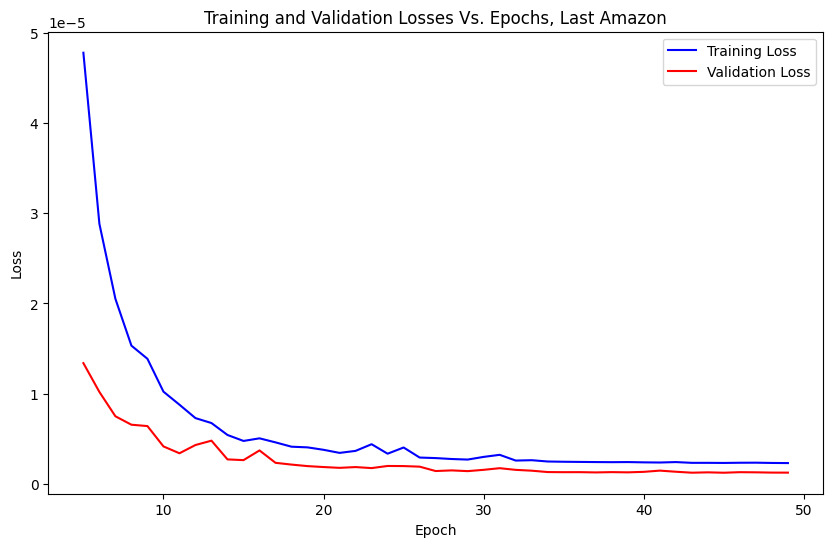

In [24]:
AMZN_trainer.plot_losses(from_epoch=5)

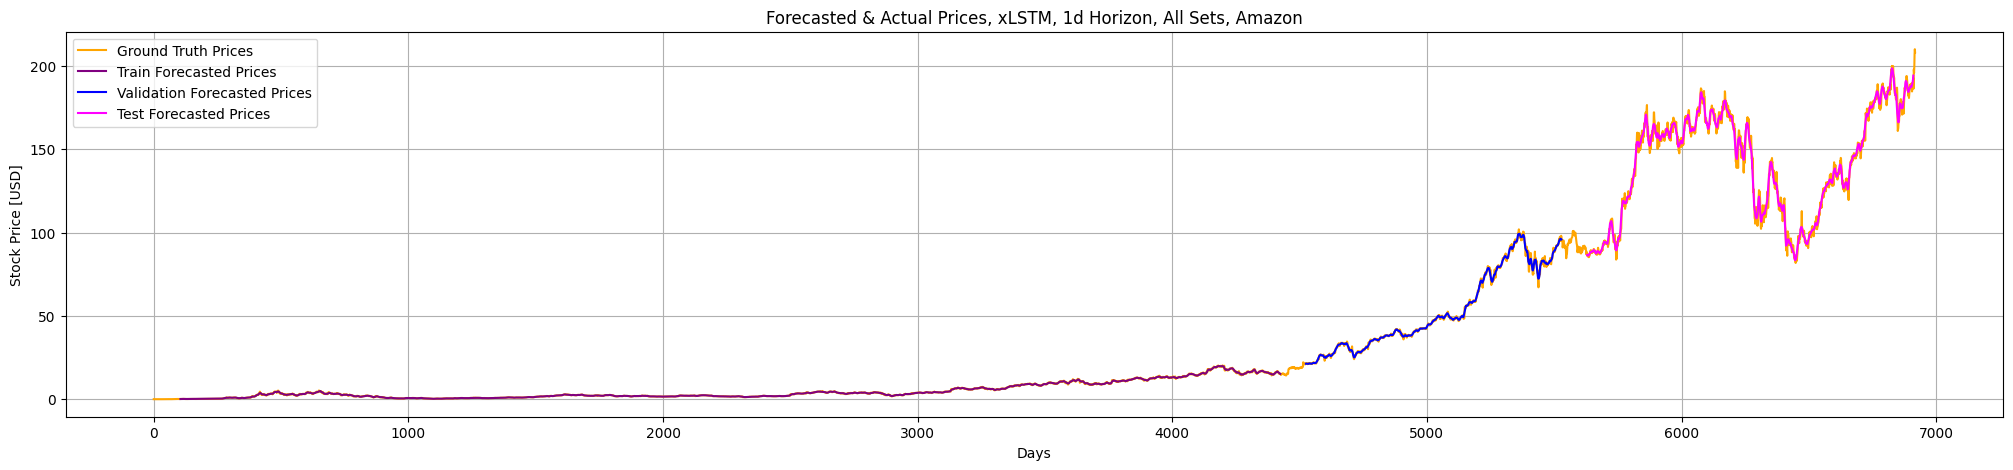

In [25]:
AMZN_trainer.plot_set('all')

Test loss: 2.156E-06


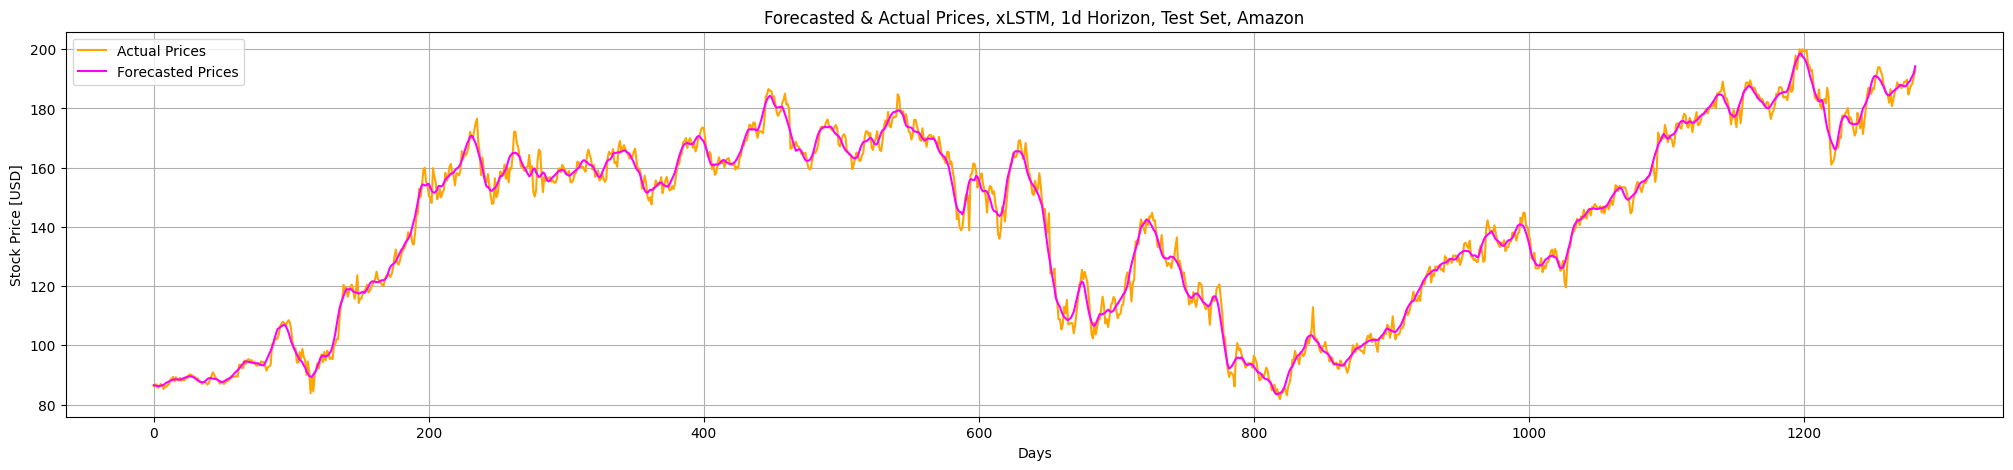

In [26]:
AMZN_trainer.plot_set('test')

--2024-11-09 16:21:57--  https://raw.githubusercontent.com/GalMichaeli/Stock-Price-Forecasting-with-xLSTM/refs/heads/main/data/AMZN_RWKV.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11572 (11K) [text/plain]
Saving to: ‘AMZN_RWKV.csv’

AMZN_RWKV.csv       100%[===================>]  11.30K  --.-KB/s    in 0s      

2024-11-09 16:21:57 (119 MB/s) - ‘AMZN_RWKV.csv’ saved [11572/11572]



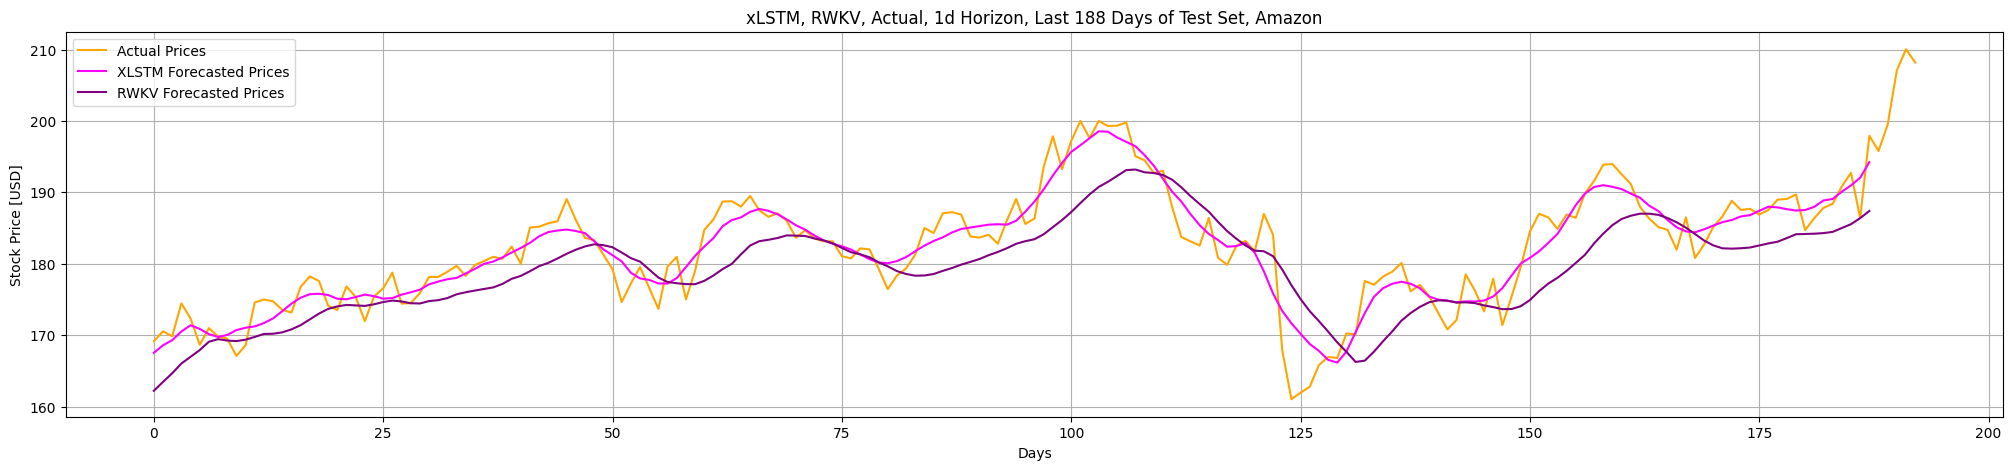

In [27]:
AMZN_trainer.plot_set('rwkv')

# Forecasting Longer Horizons with Autoregression - Coca-Cola

In [28]:
%%capture
mod_test_loader = DataLoader(KO_trainer.test_set_tensor, batch_size=1, shuffle=False)

iterator = iter(mod_test_loader)
X_batch, _ = next(iterator)
X_batch = X_batch.to(device)
window = X_batch[0:1, :, :]

fig, ax = plt.subplots(figsize=(12, 4))

In [29]:
def frame(w):
    ax.clear()
    global KO_trainer, iterator, X_batch, window

    KO_trainer.model.eval()
    with torch.no_grad():
        descaled_log_prices = KO_trainer.scaler.inverse_transform(window[0, :, :].cpu().detach().numpy())
        prices = np.exp(descaled_log_prices[:, -1])
        gt_prices = np.exp(KO_trainer.scaler.inverse_transform(X_batch[0, :, :].cpu().detach().numpy())[:, -1])

        ax.set_title("Forcasting 100 Days, Coca-Cola")
        ax.set_xlabel("Days")
        ax.set_ylabel("Adj Close Price")
        ax.plot(prices, label='Predicted Prices', color='g')
        plot = ax.plot(gt_prices, label='10-Day Moving Average Prices', color='m')
        ax.legend()

        # Update the current window
        pred = KO_trainer.model(window)
        window = torch.cat((window[:, 1:, :], pred), axis=1)
        X_batch, _ = next(iterator)

        return plot

In [ ]:
%matplotlib notebook
anim = FuncAnimation(fig=fig, func=frame, frames=100, interval=100, repeat=True)
# To save the animation as .mp4, comment the following line, then uncomment and run the next cell
HTML(anim.to_jshtml())

In [31]:
# writervideo = animation.FFMpegWriter(fps=10)
# anim.save('forecast-longer.mp4', writer=writervideo)